In [35]:
import random
import tensorflow as tf
import math
from IPython import display
import numpy as np

In [2]:
from res.plot_lib import plot_data, plot_model, set_default
from matplotlib import pyplot as plt

In [3]:
seed = 1
random.seed(seed)
tf.random.set_seed(seed)
N = 1000  # num_samples_per_class
D = 1  # dimensions
C = 1  # num_classes
H = 100  # num_hidden_units

In [10]:
X = tf.expand_dims(tf.linspace(-1, 1, 100), axis=1)
y = tf.math.pow(X,3) + 0.3 * tf.random.uniform(X.shape, dtype = tf.dtypes.float64)

In [13]:
print("Shapes:")
print("X:", X.shape)
print("y:", y.shape)

Shapes:
X: (100, 1)
y: (100, 1)


(-1.1, 1.1, -1.080588647002493, 1.2260135963594054)

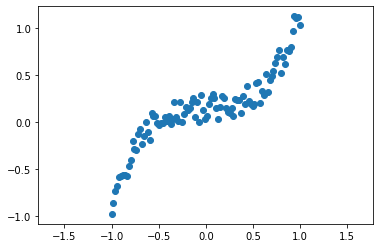

In [16]:
plt.scatter(X.numpy(), y.numpy())
plt.axis('equal')

### Linear Model

In [17]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(units = H, input_shape = (D,)),
    tf.keras.layers.Dense(units = C)
])

criterion = tf.keras.losses.MSE
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

for t in range(1000):
    
    # Feed forward to get the logits
    with tf.GradientTape() as tape:
        y_pred = model(X)
        loss = tf.reduce_mean(criterion(y, y_pred))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Compute the loss and accuracy
    print(loss)
    print("[EPOCH]: %i, [LOSS]: %.6f" % (t, loss.numpy()))
    display.clear_output(wait=True)
    

tf.Tensor(0.031964954, shape=(), dtype=float32)
[EPOCH]: 999, [LOSS]: 0.031965


In [25]:
# Plot trained model
print(model)

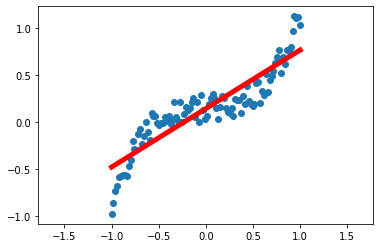

In [28]:
plt.scatter(X.numpy(), y.numpy())
plt.plot(X.numpy(), y_pred.numpy(), 'r-', lw=5)
plt.axis('equal');

### Two-layered network

In [50]:
# Number of networks
n_networks = 10
models = list()
y_pretrain = list()



criterion = tf.keras.losses.MSE

for mod in range(n_networks):
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units = H, input_shape = (D,)),
        tf.keras.layers.ReLU() if mod < n_networks // 2 else tf.keras.layers.Activation(tf.keras.activations.tanh),
        tf.keras.layers.Dense(units = C)
    ])
    
    

    for t in range(1000):

        # Feed forward to get the logits
        with tf.GradientTape() as tape:
            y_pred = model(X)
            loss = tf.reduce_mean(criterion(y, y_pred))
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        # Append pre-train output
        if t == 0:
            y_pretrain.append(y_pred)

        # Compute the loss and accuracy

        print(loss)
        print("[MODEL]: %i, [EPOCH]: %i, [LOSS]: %.6f" % (mod, t, loss.numpy()))
        display.clear_output(wait=True)
        
    models.append(model)

tf.Tensor(0.032194342, shape=(), dtype=float32)
[MODEL]: 9, [EPOCH]: 999, [LOSS]: 0.032194


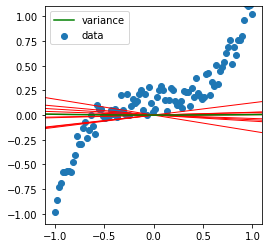

In [51]:

for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new = tf.expand_dims(tf.linspace(-2, 2, 100), axis=1)
        
    plt.plot(X_new.numpy(), y_pretrain_idx.numpy(), 'r-', lw=1)

plt.scatter(X.numpy(), y.numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = tf.stack(y_pretrain)
plt.plot(X_new.numpy(), np.var(y_combo.numpy(), axis=0), 'g', label='variance');
plt.legend()

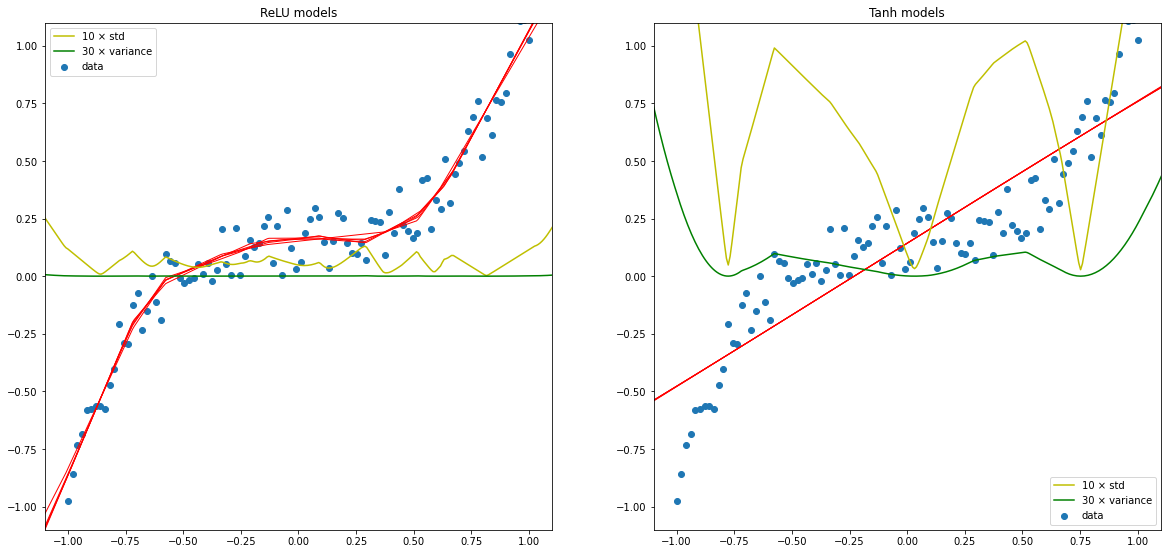

In [52]:
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = tf.expand_dims(tf.linspace(-4, 4, 1001), axis=1)

        # Getting predictions from input
        y_pred.append(model(X_new))

        plt.plot(X_new.numpy(), y_pred[-1].numpy(), 'r-', lw=1)
    plt.scatter(X.numpy(), y.numpy(), label='data')
    plt.axis('square')
    plt.axis(tf.constant((-1.1, 1.1, -1.1, 1.1)) * zoom);
    y_combo = tf.stack(y_pred)
    plt.plot(X_new.numpy(), 10 * np.std(y_combo.numpy(), axis=0), 'y', label='10 × std')
    plt.plot(X_new.numpy(), 10 * np.var(y_combo.numpy(), axis=0), 'g', label='30 × variance')
    plt.legend()
    plt.title(non_linearity + ' models')

z = 1  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)